In [2]:
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.pyplot as plt

import gpflow
import numpy as np 
import tensorflow as tf
gpflow.config.set_default_float(np.float32)
np.random.seed(1234)
tf.random.set_seed(1234)

from sgptools.methods import *
from sgptools.kernels import get_kernel
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params
from hex import *

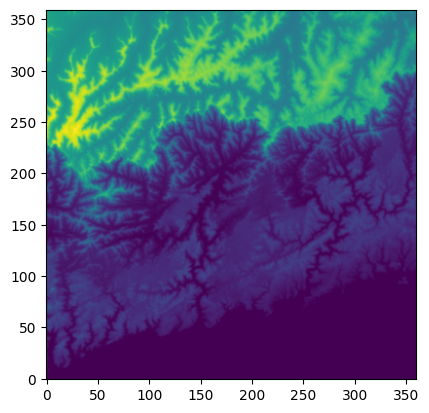

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (20000, 2), (20000, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


2025-12-05 15:56:44.137473: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000, num_test=20000)
X_train, y_train = dataset.get_train()

# Train GP/Kernel 
_, noise_variance, kernel, model = get_model_params(
    X_train=X_train, y_train=y_train, 
    kernel=get_kernel('RBF')(),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=False)

In [4]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

In [5]:
# ---------------- Generate X_test, y_test, y_test_ls ----------------
x_dim, y_dim = 100, 100
X_test = get_grid(X_train, x_dim, y_dim)
print("Test Set Dims:", X_test.shape)
y_test, _ = model.predict_f(X_test)
#y_test_ls = kernel.get_lengthscales(X_test)
y_test = y_test.numpy()

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Test Set Dims: (10000, 2)


In [6]:
# ---------------- Generate X_cand (grid with spacing set to minimum radius) ----------------
max_var = 0.4
min_r = 1/2
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

# Define the number of points in each dimension
cand_x_dim = np.ceil((x_max-x_min)/min_r).astype(int)
cand_y_dim = np.ceil((y_max-y_min)/min_r).astype(int)

X_cand = get_grid(X_train, cand_x_dim, cand_y_dim)
print("Candidate Set Dims:", X_cand.shape)
print(f"Minumum Radius: {min_r:.2f}")

Candidate Set Dims: (4900, 2)
Minumum Radius: 0.50


In [7]:
var_threshold = 0.4
cmodel = get_method('HexCoverage')(num_sensing=500,
                                   X_objective=X_train,
                                   kernel=kernel,
                                   noise_variance=noise_variance,
                                   X_candidates=X_cand)
X_sol, fovs = cmodel.optimize(var_threshold=var_threshold, 
                              return_fovs=True)
X_sol = X_sol[0]
print(f"Num Sol Points: {len(fovs)}")

Num Sol Points: 94


In [8]:
y_sol, _ = model.predict_f(X_sol)
_, _, _, model_sol = get_model_params(
    X_train=X_sol, y_train=y_sol, 
    kernel=kernel,
    noise_variance=noise_variance,
    max_steps=0,
    return_model=True,
    verbose=False)
mean, var = model_sol.predict_f(X_test)

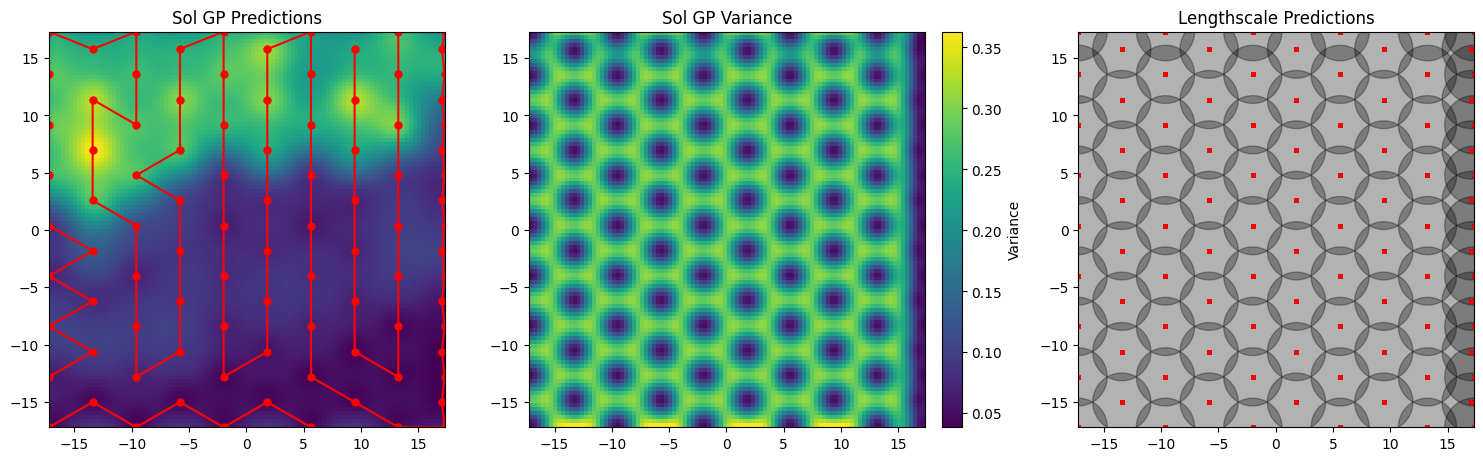

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

# First subplot — training data
sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
axes[0].plot(X_sol[:, 0], X_sol[:, 1], c='r')
axes[0].set_title("Sol GP Predictions")
axes[0].set_aspect('equal')

sc2 = axes[1].imshow(var.numpy().reshape(x_dim, y_dim).T, 
                     extent=extent, origin="lower")
axes[1].set_title("Sol GP Variance")
axes[1].set_aspect('equal')
fig.colorbar(sc2, ax=axes[1], orientation='vertical', 
             fraction=0.05, pad=0.04, label='Variance')

#sc3 = axes[2].imshow(y_test_ls.reshape(x_dim, y_dim).T,
#                     extent=extent, origin="lower")
axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)

for fov in fovs:
    patch = MplPolygon(list(fov.exterior.coords), 
                    closed=True, 
                    facecolor='k', 
                    edgecolor='k', 
                    alpha=0.3)
    axes[2].add_patch(patch)
    axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
axes[2].set_title("Lengthscale Predictions")
axes[2].set_aspect('equal')
axes[2].set_xlim(axes[1].get_xlim())
axes[2].set_ylim(axes[1].get_ylim())
#fig.colorbar(sc3, ax=axes[2], orientation='vertical', 
#             fraction=0.05, pad=0.04, label='Lengthscale')

plt.show()